In [187]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Loading Data and Inspecting

In [0]:
#Source
#https://www.kaggle.com/joniarroba/noshowappointments
data = pd.read_csv('/content/drive/My Drive/KaggleV2-May-2016.csv')
#data = pd.read_csv('KaggleV2-May-2016.csv')

In [100]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [228]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


# Feature Engineering

In [0]:
# map labels to 1/0

data['Labels'] = data['No-show'].map({'Yes': 1, 'No': 0})

Creating new features; "high_temp" and "rainfall" - giving highest temperature (in C) and total rainfall (in mm) for each appointment day.

In [0]:
# map appointment days to historical weather data, obtained from https://www.worldweatheronline.com/vitoria-weather-history/espirito-santo/br.aspx

# daily high temp (in C)
temps_dict = {'2016-06-06T00:00:00Z' : 31,
              '2016-05-16T00:00:00Z' : 28,
              '2016-05-09T00:00:00Z' : 28,
              '2016-05-30T00:00:00Z' : 28,
              '2016-06-08T00:00:00Z' : 24,
              '2016-05-11T00:00:00Z' : 29,
              '2016-06-01T00:00:00Z' : 29,
              '2016-06-07T00:00:00Z' : 27,
              '2016-05-12T00:00:00Z' : 27,
              '2016-05-02T00:00:00Z' : 24,
              '2016-05-18T00:00:00Z' : 25,
              '2016-05-17T00:00:00Z' : 28,
              '2016-06-02T00:00:00Z' : 30,
              '2016-05-10T00:00:00Z' : 28,
              '2016-05-31T00:00:00Z' : 25,
              '2016-05-05T00:00:00Z' : 26,
              '2016-05-19T00:00:00Z' : 24,
              '2016-05-03T00:00:00Z' : 25,
              '2016-05-04T00:00:00Z' : 27,
              '2016-06-03T00:00:00Z' : 27,
              '2016-05-24T00:00:00Z' : 24,
              '2016-05-13T00:00:00Z' : 25,
              '2016-05-25T00:00:00Z' : 23,
              '2016-05-06T00:00:00Z' : 26,
              '2016-05-20T00:00:00Z' : 24,
              '2016-04-29T00:00:00Z' : 24,
              '2016-05-14T00:00:00Z' : 23}

# total rainfall on that day (in mm)
rain_dict = {'2016-06-06T00:00:00Z' : 0,
              '2016-05-16T00:00:00Z' : 0.03,
              '2016-05-09T00:00:00Z' : 0.12,
              '2016-05-30T00:00:00Z' : 0.37,
              '2016-06-08T00:00:00Z' : 2.67,
              '2016-05-11T00:00:00Z' : 0,
              '2016-06-01T00:00:00Z' : 0,
              '2016-06-07T00:00:00Z' : 1.26,
              '2016-05-12T00:00:00Z' : 5.3,
              '2016-05-02T00:00:00Z' : 0,
              '2016-05-18T00:00:00Z' : 1.67,
              '2016-05-17T00:00:00Z' : 0.74,
              '2016-06-02T00:00:00Z' : 0.38,
              '2016-05-10T00:00:00Z' : 0,
              '2016-05-31T00:00:00Z' : 1.53,
              '2016-05-05T00:00:00Z' : 0.02,
              '2016-05-19T00:00:00Z' : 0.56,
              '2016-05-03T00:00:00Z' : 0.47,
              '2016-05-04T00:00:00Z' : 0.13,
              '2016-06-03T00:00:00Z' : 2.2,
              '2016-05-24T00:00:00Z' : 0.1,
              '2016-05-13T00:00:00Z' : 0.28,
              '2016-05-25T00:00:00Z' : 1.08,
              '2016-05-06T00:00:00Z' : 0.34,
              '2016-05-20T00:00:00Z' : 0.84,
              '2016-04-29T00:00:00Z' : 3.58,
              '2016-05-14T00:00:00Z' : 1.16}          

data['high_temp'] = data['AppointmentDay'].map(temps_dict)  
data['rainfall'] = data['AppointmentDay'].map(rain_dict)


Creating new feature - "impeachment_vote" - most significant news story in Brazil during this range of dates was Senate voting to impeach the president on May 12, 2016.  Can distractions like this affect appointment compliance?

In [0]:
# 1 for impeachment date, 0 for all others
data['impeachment_vote'] = 0
data['impeachment_vote'] = data['AppointmentDay'].map(lambda x: 1 if x == '2016-05-12T00:00:00Z' else 0)

Tried to create a new features of neighbourhood, by finding the neighbourhood with highest no-show frequency that is also on the top 10 list of most prevalent neighbourhoods in the data, it was 'Bonfim.'

However this has weak correlation with the labels and isn't used. 

In [233]:
#Neighbourhoods
pd.crosstab(data['Neighbourhood'],data['No-show']).apply(lambda x: x/x.sum(), axis=1).head(10).sort_values(by='Yes',ascending=False)

No-show,No,Yes
Neighbourhood,,
CARATOÍRA,0.769591,0.230409
ANDORINHAS,0.769673,0.230327
BENTO FERREIRA,0.775058,0.224942
ARIOVALDO FAVALESSA,0.780142,0.219858
BARRO VERMELHO,0.784870,0.215130
BELA VISTA,0.798637,0.201363
BONFIM,0.801659,0.198341
BOA VISTA,0.814103,0.185897
ANTÔNIO HONÓRIO,0.815498,0.184502


In [0]:
# Bonfim is the neighbourhood with largest proportion of "yes," that is also on the top 10 most prevalent neighbourhoods int the dataset
data['Neighbourhood_bonfim'] = 0
data['Neighbourhood_bonfim'][data['Neighbourhood']=='BONFIM'] = 1

Create new time-based features;

days_to_appt - days between scheduled date and appt date 

day_of_appt - day of the week of the appointment

day_of_scheduling - day of the week of scheduling date

month_of_appt - month of the year of the appointment

month_of_scheduling - month of the year of the scheduling date

hour_of_scheduling - hour of the scheduling time (there is no time for appointment dates)


In [0]:
# convert date objects to datetime format (without time part)
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['ScheduledDayDT'] = pd.to_datetime((data['ScheduledDayDT']),utc=True)
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDay'])

In [0]:
# create new feature - "days_to_appt" - no. of days between scheduled date and appt date
data['time_between_appts'] = data['AppointmentDayDT']-data['ScheduledDayDT']
data['days_to_appt'] = data['time_between_appts']/np.timedelta64(1,'D')

In [0]:
# create new features - day of the week and month of the year of the scheduling and appointment dates, hour of scheduling
data['day_of_appt'] = data['AppointmentDayDT'].dt.dayofweek
data['day_of_scheduling'] = data['ScheduledDayDT'].dt.dayofweek
data['month_of_appt'] = data['AppointmentDayDT'].dt.month
data['month_of_scheduling'] = data['ScheduledDayDT'].dt.month
data['hour_of_scheduling'] = pd.to_datetime(data['ScheduledDay']).dt.hour

Not using these but maybe useful to look at;

In [0]:
#Has the same Patient been there before (e.g same PatientID appears multiple times)?
data['count_visits'] = data.groupby('PatientId')['PatientId'].transform('count')
#data.loc[data['PatientId'] == 22638656.0]

#How many total no-shows does the specific patient have in the dataset?
data['total_no_shows'] = data.groupby('PatientId')['Labels'].transform('sum')


Create new features regarding past patient history;

prior_no_shows - # of no shows patient had prior to current appt

prior_visits - # of visits patient had prior to current appt

visit_freq - frequency of visits (appts/day for each pt, = 0 if they only had one appt 
in the dataset)

In [0]:
# loop below takes several mins to run, you can just read in the data by running the cell below this one

data['prior_no_shows'] = 0
data['prior_visits'] = 0
data['visit_freq'] = 0

for i in data.index: 
  
  # how many no-shows and overall visits happened for this PatientId, prior to current date?
  data.loc[i,'prior_no_shows']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT']) & (data['Labels']==1)])
  data.loc[i,'prior_visits']=len(data[(data['PatientId']==data.loc[i,'PatientId']) & (data['AppointmentDayDT']<data.loc[i,'AppointmentDayDT'])])

  # visit frequency = total visits/(latest-earliest visit)
  max_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].max()
  min_date = data[data['PatientId']==data.loc[i,'PatientId']]['AppointmentDayDT'].min()
  
  if (max_date>min_date): # if there's only 1 appt it stays as zero
      data.loc[i,'visit_freq'] = float(len(data[data['PatientId']==data.loc[i,'PatientId']]))/((max_date-min_date)/np.timedelta64(1,'D'))   

# write the new columns to disk or google drive
data[['prior_no_shows','prior_visits','visit_freq']].to_csv('prior_no_shows.csv')    
!cp prior_no_shows.csv drive/My\ Drive/  # only if using colab

In [0]:
# use this to just read in the data instead of running the cells above
prior_no_shows = pd.read_csv('/content/drive/My Drive/prior_no_shows.csv') # change to local dir if not using colab
data['prior_no_shows'] = prior_no_shows['prior_no_shows']
data['prior_visits'] = prior_no_shows['prior_visits']
data['visit_freq'] = prior_no_shows['visit_freq']


Correlation and Heat map

In [242]:
#Correlation analysis
corr=data.corr()
corr['Labels'].sort_values(ascending=False)

Labels                  1.000000
total_no_shows          0.462508
days_to_appt            0.186231
SMS_received            0.126431
prior_no_shows          0.078592
hour_of_scheduling      0.060697
Scholarship             0.029135
day_of_scheduling       0.006020
day_of_appt             0.001165
Alcoholism             -0.000196
high_temp              -0.001033
Neighbourhood_bonfim   -0.001435
PatientId              -0.001461
impeachment_vote       -0.005801
Handcap                -0.006076
rainfall               -0.014748
Diabetes               -0.015180
visit_freq             -0.016729
prior_visits           -0.020710
month_of_appt          -0.020886
count_visits           -0.031194
Hipertension           -0.035701
Age                    -0.060319
month_of_scheduling    -0.160862
AppointmentID          -0.162602
Name: Labels, dtype: float64

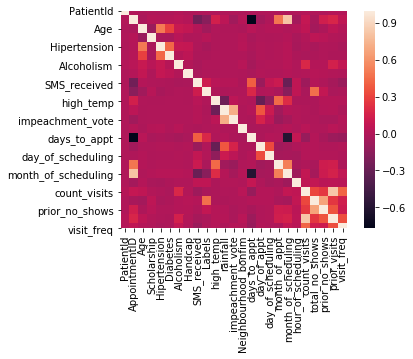

In [243]:
#Heatmap
ax = sns.heatmap(corr,  square=True)

In [244]:
# check balance of labels

no = len(data[data['No-show']=='No'])
yes = len(data[data['No-show']=='Yes'])
total = len(data)

print('Number of Rows with No-Show = Yes: ', yes,'(',np.round(yes/total*100,2),'%), Number of rows with No-show = No: ', no,'(',np.round(no/total*100,2),'%)')

Number of Rows with No-Show = Yes:  22319 ( 20.19 %), Number of rows with No-show = No:  88208 ( 79.81 %)


In [0]:
# keep only desired features and labels
data_clean = data[['Labels','Gender','Age','SMS_received','day_of_appt','day_of_scheduling','month_of_appt','month_of_scheduling','hour_of_scheduling','days_to_appt','prior_no_shows','prior_visits',
                   'high_temp','rainfall','visit_freq','Scholarship']]

# disease features are dropped for now due to strong correlation with Age and very weark correlation with Labels

## 3. Prepare for Modelling

The cleaned data is divided into train/test sets (70/30) ratio. OneHotEncoder() is used for all categorical features (except the ones already encoded from the source) and StandardScaler() for numerical features.

In [258]:
data_clean.columns

Index(['Labels', 'Gender', 'Age', 'SMS_received', 'day_of_appt',
       'day_of_scheduling', 'month_of_appt', 'month_of_scheduling',
       'hour_of_scheduling', 'days_to_appt', 'prior_no_shows', 'prior_visits',
       'high_temp', 'rainfall', 'visit_freq', 'Scholarship'],
      dtype='object')

In [259]:
# split into test/train
train_set,test_set = train_test_split(data_clean,test_size=0.3,stratify=data_clean["Labels"])
print(len(train_set), "train +", len(test_set), "test")

# divide into features/labels
train_features = train_set.drop('Labels',axis=1)
train_labels = train_set[['Labels']]
test_features = test_set.drop('Labels',axis=1)
test_labels = test_set[['Labels']]

77368 train + 33159 test


In [0]:
# transform numerical and categorical features using StandardScaler() and OneHotEncoder()
num_attribs = ['Age','days_to_appt','prior_no_shows','high_temp','rainfall','prior_visits','visit_freq']
cat_attribs_one_hot = ['Gender','day_of_appt','day_of_scheduling','month_of_appt','month_of_scheduling','hour_of_scheduling']

pipeline_features = ColumnTransformer(
    [("num",StandardScaler(),num_attribs),("cat",OneHotEncoder(categories='auto',handle_unknown='ignore'),cat_attribs_one_hot)],remainder='passthrough')

train_features_prepared = pipeline_features.fit_transform(train_features)
train_labels_prepared = train_labels.values

test_features_prepared = pipeline_features.transform(test_features)
test_labels_prepared = test_labels.values

In [261]:
train_features_prepared.shape

(77368, 49)

In [262]:
test_features_prepared.shape

(33159, 49)

## 4. Testing Some Models

Logistic Regression, Random Forest and XGBoost Classifiers are tested below on train set, using 3 cv-folds.  Each is run using no class weighting first, followed by setting class_weight = 'balanced'.  Setting weight to 'balanced' causes the classifiers to put more weight on results of the minority class ('Yes') to try and account for class imbalance.

In [0]:
# This Function Runs Several Classifiers on Training Data with 3 cv-folds, Prints Out "metric" score of each Model
 
def testClassifiers(features,labels,metric=[]):
 
 # all models
    DTC=DecisionTreeClassifier()
    GBC=GradientBoostingClassifier()
    KNN=KNeighborsClassifier()
    SGD=SGDClassifier()
    SVC_rbf = SVC(kernel="rbf",class_weight='balanced') #This runs very slow!
    SVC_lin = SVC(kernel='linear',class_weight='balanced')
    ADA = AdaBoostClassifier()
    MLP = MLPClassifier()
    GNB = GaussianNB()
 
# models used for now
    LOG_no_weights=LogisticRegression()
    LOG_weighted=LogisticRegression(class_weight='balanced')
    RFC_no_weights=RandomForestClassifier(n_estimators=100)
    RFC_weighted=RandomForestClassifier(n_estimators=100,class_weight='balanced')
    XGB_no_weights = XGBClassifier()
    XGB_weighted = XGBClassifier(scale_pos_weight=4)

    classifier_list = [LOG_no_weights,LOG_weighted,RFC_no_weights,RFC_weighted,XGB_no_weights,XGB_weighted]

    for c in classifier_list:
        print(type(c).__name__)

        for m in metric:
            cv_results = cross_val_score(c,features,labels,cv=3,scoring=m)
            print('-------------------')
            print('Scoring Metric: ', m)
            print('Scores: ',cv_results)
            print('Mean Score: ',np.round(np.mean(cv_results),2))
            print('')

In [264]:
# testing out Logistic Regression, Random Forest, XGBoost (each unweighted followed by weighted)
testClassifiers(train_features_prepared,train_labels_prepared, ['accuracy','precision','recall'])

LogisticRegression
-------------------
Scoring Metric:  accuracy
Scores:  [0.79654905 0.79728577 0.79556383]
Mean Score:  0.8

-------------------
Scoring Metric:  precision
Scores:  [0.44380403 0.46855346 0.41144414]
Mean Score:  0.44

-------------------
Scoring Metric:  recall
Scores:  [0.02956989 0.02860983 0.02899942]
Mean Score:  0.03

LogisticRegression
-------------------
Scoring Metric:  accuracy
Scores:  [0.66297014 0.65917022 0.66212967]
Mean Score:  0.66

-------------------
Scoring Metric:  precision
Scores:  [0.32041237 0.31930993 0.32159577]
Mean Score:  0.32

-------------------
Scoring Metric:  recall
Scores:  [0.59677419 0.60771889 0.60687536]
Mean Score:  0.6

RandomForestClassifier
-------------------
Scoring Metric:  accuracy
Scores:  [0.79127569 0.79081039 0.79234528]
Mean Score:  0.79

-------------------
Scoring Metric:  precision
Scores:  [0.44770858 0.42523923 0.44404973]
Mean Score:  0.44

-------------------
Scoring Metric:  recall
Scores:  [0.1499616  0.142

In [0]:
### MESSING AROUND WITH RESAMPLING BELOW, IGNORE FOR NOW

I was playing around trying out models on a 50/50 yes/no sample of the train_set, and then fitting them on the original test set.  Since the models above all have accuracy suspiciously close to 80%, which is the fraction of labels that are "no."  

So this is able to improve recall and F1 but accuracy/precision is usually worse.  

In [0]:
# sample the "No-show=no" data so that yes and no are in equal amounts
yes = len(train_set[train_set['Labels']==1])

train_set_yes = train_set[train_set['Labels']==1]
train_set_no = train_set[train_set['Labels']==0].sample(yes)
train_set_5050 = pd.concat([train_set_yes,train_set_no])
train_set_5050['Labels'].value_counts()


1    15623
0    15623
Name: Labels, dtype: int64

In [0]:
# prepare balanced train data, and train a Random Forest Classifier on it
train_features_balanced = train_set_5050.drop('Labels',axis=1)
train_labels_balanced = train_set_5050[['Labels']]
train_features_balanced_prepared = pipeline_features.transform(train_features_balanced)
train_labels_balanced_prepared = train_labels_balanced.values

train_features_balanced_prepared.shape

(31246, 46)

In [0]:
RFC2 = SVC(kernel='linear')
RFC2.fit(train_features_balanced_prepared,train_labels_balanced_prepared)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
# now test resulting model on original (imbalanced) test data
pred = RFC2.predict(test_features_prepared)
print('Accuracy: ',accuracy_score(test_labels_prepared,pred))
print('Recall: ',recall_score(test_labels_prepared,pred))
print('Precision: ',precision_score(test_labels_prepared,pred))
print('ROC AUC: ',roc_auc_score(test_labels_prepared,pred))
print('F1: ',f1_score(test_labels_prepared,pred))
print(confusion_matrix(test_labels_prepared,pred))
print('Amount of No/Yes in Predicted Values: ',np.bincount(pred))

Accuracy:  0.6677221870382098
Recall:  0.5159796893667862
Precision:  0.30760327635327633
ROC AUC:  0.6110488327044035
F1:  0.3854306113342258
[[18686  7777]
 [ 3241  3455]]
Amount of No/Yes in Predicted Values:  [21927 11232]


In [0]:
# now for comparison, train Random Forest on original (imbalanced) train set and test on test set..
RFC3 = XGBClassifier()
RFC3.fit(train_features_prepared,train_labels_prepared)
pred = RFC3.predict(test_features_prepared)
print('Accuracy: ',accuracy_score(test_labels_prepared,pred))
print('Recall: ',recall_score(test_labels_prepared,pred))
print('Precision: ',precision_score(test_labels_prepared,pred))
print('ROC AUC: ',roc_auc_score(test_labels_prepared,pred))
print('F1: ',f1_score(test_labels_prepared,pred))
print('Amount of No/Yes in Predicted Values: ',np.bincount(pred))

Accuracy:  0.7749932145118972
Recall:  0.20654121863799282
Precision:  0.39167374681393374
ROC AUC:  0.5626856416282585
F1:  0.27046054561454974
Amount of No/Yes in Predicted Values:  [29628  3531]


In [0]:
# accuracy/precision improve but other scores get worse, not sure if the models have any predictive ability so far or are just guessing

In [0]:
#Sampling data to 50/50 prior to dividing into test/train;
yes_data_clean = len(data_clean[data_clean['Labels']==1])

data_clean_yes = data_clean[data_clean['Labels']==1]
data_clean_no = data_clean[data_clean['Labels']==0].sample(yes_data_clean)
data_clean_5050 = pd.concat([data_clean_yes,data_clean_no])
data_clean_5050['Labels'].value_counts()

train_set_5050,test_set_5050 = train_test_split(data_clean_5050,test_size=0.3,stratify=data_clean_5050["Labels"])
print(len(train_set_5050), "train +", len(test_set_5050), "test")

# divide into features/labels
train_features_5050 = train_set_5050.drop('Labels',axis=1)
train_labels_5050 = train_set_5050[['Labels']]
test_features_5050 = test_set_5050.drop('Labels',axis=1)
test_labels_5050 = test_set_5050[['Labels']]

train_features_5050_prepared = pipeline_features.fit_transform(train_features_5050)
train_labels_5050_prepared = train_labels_5050.values

test_features_5050_prepared = pipeline_features.transform(test_features_5050)
test_labels_5050_prepared = test_labels_5050.values


31246 train + 13392 test


In [0]:
RFC3 = XGBClassifier()
RFC3.fit(train_features_5050_prepared,train_labels_5050_prepared)
pred = RFC3.predict(test_features_5050_prepared)
print('Accuracy: ',accuracy_score(test_labels_5050_prepared,pred))
print('Recall: ',recall_score(test_labels_5050_prepared,pred))
print('Precision: ',precision_score(test_labels_5050_prepared,pred))
print('ROC AUC: ',roc_auc_score(test_labels_5050_prepared,pred))
print('F1: ',f1_score(test_labels_5050_prepared,pred))
print('Amount of No/Yes in Predicted Values: ',np.bincount(pred))

Accuracy:  0.6777180406212664
Recall:  0.8315412186379928
Precision:  0.6359068067610781
ROC AUC:  0.6777180406212665
F1:  0.720683406678747
Amount of No/Yes in Predicted Values:  [4636 8756]


In [0]:
|importances = RFC3.feature_importances_
indices = np.argsort(RFC3.feature_importances_)[::-1]

for f in range(train_features_5050_prepared.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

SyntaxError: ignored